In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from keras import datasets
import matplotlib.pyplot as plt

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import the module from the custom library
from src.architectures.sequential import Sequential
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, activations, loss_functions, optimizers, metrics, callbacks

### Constants and hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'fashion_mnist_classifier')

In [3]:
train_test_split_pct = 0.1 # Percentage of samples to use for testing
train_valid_split = 0.1 # Percentage of samples to use for validation
learning_rate = 3e-4 # Learning rate for the optimizer
batch_size = 256 # Number of samples to use for each batch
epochs = 30 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Add the channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Extract the number of classes in the dataset
num_classes = len(np.unique(train_labels))    

# Convert the lists to numpy arrays
X_train = Tensor(np.array(train_images))
y_train = Tensor(np.array(train_labels), dtype=np.int8)
X_test = Tensor(np.array(test_images))
y_test = Tensor(np.array(test_labels), dtype=np.int8)

# Split the training set into training, validation and testing sets
X_train, X_valid, y_train, y_valid = data_processing.split_data(data=(X_train, y_train), split_pct=train_valid_split, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data(data=(X_train, y_train), split_pct=train_valid_split, shuffle=True)[0]

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape(), y_train.shape())
print('Validation set:', X_valid.shape(), y_valid.shape())
print('Testing set:', X_test.shape(), y_test.shape())

Number of classes: 10
Training set: (48600, 28, 28, 1) (48600,)
Validation set: (5400, 28, 28, 1) (5400,)
Testing set: (10000, 28, 28, 1) (10000,)


### Data preprocessing

In [6]:
# Normalization
def normalize(X: Tensor) -> Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [7]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = data_processing.one_hot_encoding(y=y_train, n_classes=num_classes)
y_valid_encoded = data_processing.one_hot_encoding(y=y_valid, n_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0])
print("One-hot encoded value:", y_train_encoded[0])

Sample target value: Tensor(2.0, shape=(), dtype=float32)
One-hot encoded value: Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


### Data visualization

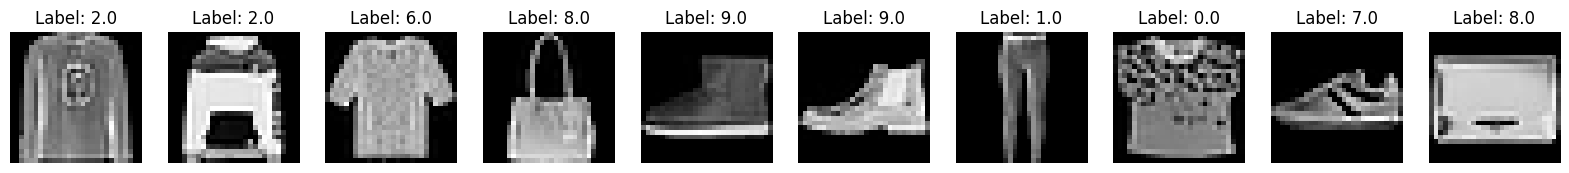

In [8]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Plot the samples in a grid
    _, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
# Plot the first 10 samples
plot_samples(list(X_train.data[:10]), list(y_train.data[:10]))

### Building the model

In [9]:
model = Sequential(
    name = "Fashion MNIST Classifier",
    modules = [
        layers.Conv2D(num_filters=32, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
        layers.MaxPool2D(size=(2, 2)),
        layers.Dropout(rate=0.1),
        layers.Conv2D(num_filters=16, kernel_size=(3, 3), activation=activations.ReLU(), padding='same'),
        layers.MaxPool2D(size=(2, 2)),
        layers.Dropout(rate=0.1),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(num_units=64, activation=activations.ReLU()),
        layers.Dense(num_units=num_classes, activation=activations.Softmax())
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.CategoricalCrossEntropy()

### Initializing the model

In [10]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    model(X_train[:batch_size])

In [11]:
# Display the model summary
model.summary()
model.modules.summary()


Fashion MNIST Classifier

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
fashion_mnist_classifier.modules (ModuleList)          (256, 10)           57402               
Total trainable parameters: 57402
-----------------------------------------------------------------------------------------------

fashion_mnist_classifier.modules

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
module_list.0 (Conv2D)                                 (256, 28, 28, 32)   320                 
-----------------------------------------------------------------------------------------------
module_list.1 (MaxPool2D)                              (256, 14, 14, 32)   0                   
----------------------------------------

### Training the model

In [12]:
history = model.fit(
    X_train = X_train,
    y_train = y_train_encoded,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid,
    y_valid = y_valid_encoded,
    batch_size = batch_size,
    epochs = epochs,
    metrics = [metrics.accuracy],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/30 --> loss: 0.8097 - accuracy: 0.74328 | Valid loss: 0.46062 - Valid accuracy: 0.84251                        
Epoch 2/30 --> loss: 0.42341 - accuracy: 0.85158 | Valid loss: 0.36444 - Valid accuracy: 0.87707                        
Epoch 3/30 --> loss: 0.35466 - accuracy: 0.8752 | Valid loss: 0.32019 - Valid accuracy: 0.88844                        
Epoch 4/30 --> loss: 0.32089 - accuracy: 0.88546 | Valid loss: 0.29058 - Valid accuracy: 0.89938                        
Epoch 5/30 --> loss: 0.29516 - accuracy: 0.89392 | Valid loss: 0.27583 - Valid accuracy: 0.904                          
Epoch 6/30 --> loss: 0.27736 - accuracy: 0.90039 | Valid loss: 0.26013 - Valid accuracy: 0.90619                        
Epoch 7/30 --> loss: 0.2657 - accuracy: 0.90303 | Valid loss: 0.24574 - Valid accuracy: 0.91134                        
Epoch 8/30 --> loss: 0.25469 - accuracy: 0.90745 | Valid loss: 0.23729 - Valid accuracy: 0.91607                        
Epoch 9/30 --> loss: 0.24383 - accu

In [13]:
# Save the model
model.save(model_path)

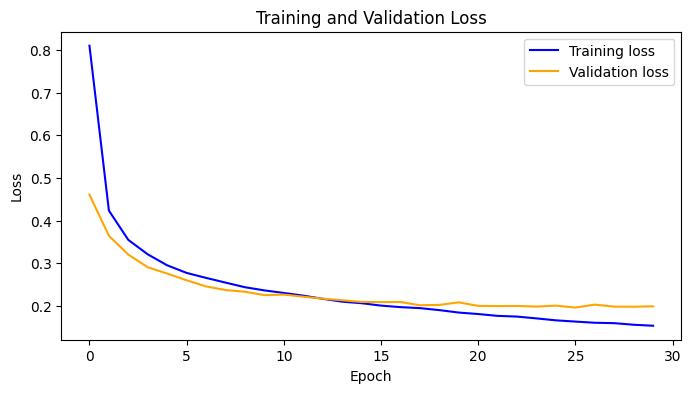

In [14]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Evaluation

In [15]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions = model(X_test, batch_size=batch_size, verbose=True)

# Apply the argmax function to the predictions
predictions = Tensor(np.argmax(predictions.data, axis=1), dtype=np.int8)

Processing batch 40/40 - 22.16 ms/step

Accuracy: 0.92


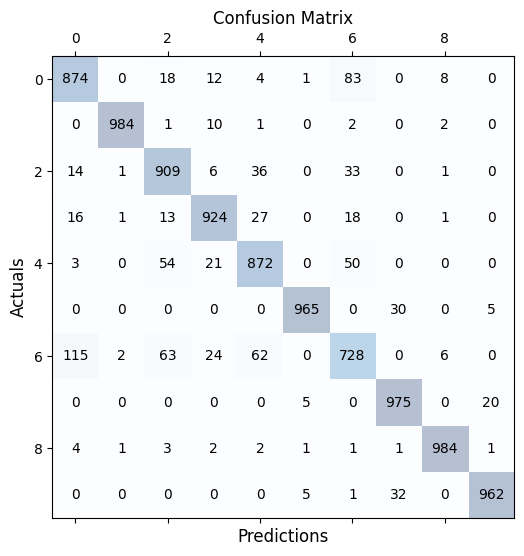

In [16]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test, predictions)
confusion_matrix = metrics.confusion_matrix(num_classes, y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy.data:.2f}")

# Plot the confusion matrix
data_analysis.plot_confusion_matrix(confusion_matrix)